In [57]:
import numpy as np
import cv2
import argparse
import matplotlib.pyplot as plt

import matplotlib.image as mpimg

import skimage 
import skimage.io
import scipy
import scipy.ndimage
import scipy.signal
%matplotlib inline

In [58]:
#models : https://github.com/richzhang/colorization/tree/caffe/colorization/models
#using pre-trained models using link above

#!wget http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel -O ./models/colorization_release_v2.caffemodel

!wget http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel -O colorization_caffemodel

#define paths for neural network
prototxt_path = 'colorization_deploy_v2.prototxt.txt'
model_path = "colorization_caffemodel"
kernel_path = 'pts_in_hull.npy'
orig_img = 'RiverMountain.png'

URL transformed to HTTPS due to an HSTS policy
--2022-06-07 06:44:25--  https://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel
Resolving eecs.berkeley.edu (eecs.berkeley.edu)... 23.185.0.1, 2620:12a:8001::1
Connecting to eecs.berkeley.edu (eecs.berkeley.edu)|23.185.0.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://people.eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel [following]
--2022-06-07 06:44:25--  https://people.eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128946764 (123M)
Saving to: ‘colorization_caffemodel’

colorizatio

In [59]:
#define neural network, load pre-trained model from paths above
NN = cv2.dnn.readNetFromCaffe(prototxt_path, model_path)
points = np.load(kernel_path) #cluster center points/kernels for model

#reshape kernel to size 1x1 for CNN
points = points.transpose().reshape(2, 313, 1, 1)
NN.getLayer(NN.getLayerId("class8_ab")).blobs = [points.astype(np.float32)]
NN.getLayer(NN.getLayerId("conv8_313_rh")).blobs = [np.full([1, 313], 2.606, dtype = "float32")]

#this model uses LAB color scheme (different from RGB) --> L = lightness, "a/b" are color values
#loading centers for channel quantization for "a and b"
#a blob is an N-dimensional array stored in a C-contiguous fashion. Caffe stores and communicates data using blobs. 
#(wrapper over the actual data being processed and passed along by Caffe, and also under the hood provides synchronization capability between the CPU and the GPU)

bw_image = cv2.imread(orig_img) #load black and white image
normalized = bw_image.astype("float32") / 255.0 # obtains value in between 0 and 1 (rgb values from 0 to 255) 
LAB_img = cv2.cvtColor(normalized, cv2.COLOR_BGR2LAB) #BGR used instead of RGB because imread from openCV loads image in BGR format

#resize image to fit model parameters of 224 x 224 pixels
resized_img = cv2.resize(LAB_img, (224, 224))

#split the channels
L = cv2.split(resized_img)[0] #lightness
L = L - 50 #subtract the mean value - levelling uneven sections of an image such as half an image having a shadow on it, or detecting changes between two images.

#feed in lightness values into neural net to obtain "a" and "b" color values
NN.setInput(cv2.dnn.blobFromImage(L)) #lightness value is input into neural net
AB = NN.forward()[0, :, :, :].transpose((1,2,0)) #obtain A and B color values by passing L value through neural net

#resize image back into original pixel dimensions 
AB = cv2.resize(AB, (bw_image.shape[1], bw_image.shape[0]))
L = cv2.split(LAB_img)[0] #obtain original lightness levels back from initial image

colorized_img = np.concatenate((L[:,:,np.newaxis], AB), axis=2) #combine lightness values with new predicted "A" and "B" color values

#convert back from LAB color scheme to BGR color scheme
colorized_img = cv2.cvtColor(colorized_img, cv2.COLOR_LAB2BGR)

#normalized before by dividing by 255, scale back to original by multiplying by 255
colorized_img = (colorized_img * 255.0).astype("uint8")

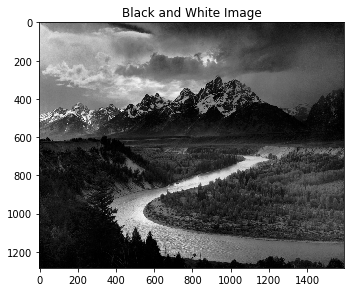

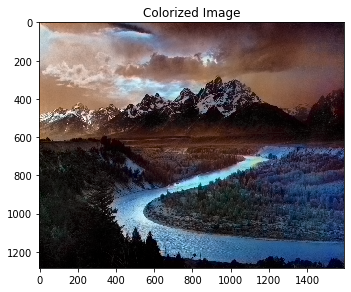

In [60]:
#Now, display the prior black and white image, and the predicted color image!

skimage.io.imshow(orig_img)
plt.title("Black and White Image")
plt.show()

skimage.io.imshow(colorized_img)
plt.title("Colorized Image")
plt.show()
